<a href="https://colab.research.google.com/github/LeopoldGmelin/Projects/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

In [2]:
from google.colab import files
uploaded = files.upload()

Saving temperatur_dk_2017_2022.csv to temperatur_dk_2017_2022.csv


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/3000
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5081 - mae: 0.4880
Epoch 1: val_loss improved from inf to 0.74862, saving model to best_model.h5


436/436 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.5076 - mae: 0.4877 - val_loss: 0.7486 - val_mae: 0.6905 - learning_rate: 0.0010
Epoch 2/3000
421/436 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1517 - mae: 0.2471
Epoch 2: val_loss improved from 0.74862 to 0.10775, saving model to best_model.h5


436/436 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1503 - mae: 0.2465 - val_loss: 0.1077 - val_mae: 0.2483 - learning_rate: 0.0010
Epoch 3/3000
429/436 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0960 - mae: 0.2030
Epoch 3: val_loss improved from 0.10775 to 0.03012, saving model to best_model.h5


436/436 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0960 - mae: 0.2030 - val_loss: 0.0301 - val_mae: 0.0996 - learning_rate: 0.0010
Epoch 4/3000
421/436 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0870 - mae: 0.1864
Epoch 4: val_loss improved from 0.03012 to 0.02756, saving model to best_model.h5


436/436 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0868 - mae: 0.1862 - val_loss: 0.0276 - val_mae: 0.0949 - learning_rate: 0.0010
Epoch 5/3000
435/436 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0639 - mae: 0.1689
Epoch 5: val_loss did not improve from 0.02756
436/436 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0640 - mae: 0.1689 - val_loss: 0.0378 - val_mae: 0.1365 - learning_rate: 0.0010
Epoch 6/3000
426/436 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0671 - mae: 0.1691
Epoch 6: val_loss did not improve from 0.02756
436/436 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0673 - mae: 0.1691 - val_loss: 0.0390 - val_mae: 0.1386 - learning_rate: 0.0010
Epoch 7/3000
435/436 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0904 - mae: 0.1787
Epoch 7: val_loss did not improve from 0.02756
436/436 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0903 - mae: 0.1787 - val_loss: 0.0371 - val_mae: 0.1107 - learning_rate: 0.0010
Epoch 8/3000
426/436 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0680 - mae: 0.1654
Epo

436/436 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1174 - mae: 0.1795 - val_loss: 0.0197 - val_mae: 0.0886 - learning_rate: 0.0010
Epoch 11/3000
427/436 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0903 - mae: 0.1683
Epoch 11: val_loss did not improve from 0.01974
436/436 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0897 - mae: 0.1680 - val_loss: 0.0461 - val_mae: 0.1526 - learning_rate: 0.0010
Epoch 12/3000
431/436 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0522 - mae: 0.1519
Epoch 12: val_loss did not improve from 0.01974
436/436 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0523 - mae: 0.1520 - val_loss: 0.1097 - val_mae: 0.2998 - learning_rate: 0.0010
Epoch 13/3000
435/436 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0560 - mae: 0.1579
Epoch 13: val_loss did not improve from 0.01974
436/436 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0560 - mae: 0.1578 - val_loss: 0.1086 - val_mae: 0.2510 - learning_rate: 0.0010
Epoch 14/3000
428/436 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0602 - mae: 0.1

436/436 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0816 - mae: 0.1514 - val_loss: 0.0177 - val_mae: 0.0624 - learning_rate: 0.0010
Epoch 36/3000
424/436 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0477 - mae: 0.1387
Epoch 36: val_loss did not improve from 0.01773
436/436 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0478 - mae: 0.1387 - val_loss: 0.0179 - val_mae: 0.0583 - learning_rate: 0.0010
Epoch 37/3000
425/436 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0397 - mae: 0.1344
Epoch 37: val_loss did not improve from 0.01773
436/436 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0398 - mae: 0.1345 - val_loss: 0.0214 - val_mae: 0.0593 - learning_rate: 0.0010
Epoch 38/3000
429/436 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0567 - mae: 0.1403
Epoch 38: val_loss did not improve from 0.01773
436/436 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0566 - mae: 0.1404 - val_loss: 0.0265 - val_mae: 0.0851 - learning_rate: 0.0010
Epoch 39/3000
423/436 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0330 - mae: 0.1

436/436 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0339 - mae: 0.1262 - val_loss: 0.0174 - val_mae: 0.0701 - learning_rate: 0.0010
Epoch 43/3000
421/436 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0518 - mae: 0.1378
Epoch 43: val_loss did not improve from 0.01742
436/436 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0515 - mae: 0.1377 - val_loss: 0.0384 - val_mae: 0.1443 - learning_rate: 0.0010
Epoch 44/3000
426/436 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0380 - mae: 0.1306
Epoch 44: val_loss did not improve from 0.01742
436/436 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0380 - mae: 0.1306 - val_loss: 0.0185 - val_mae: 0.0591 - learning_rate: 0.0010
Epoch 45/3000
422/436 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0311 - mae: 0.1294
Epoch 45: val_loss did not improve from 0.01742
436/436 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0313 - mae: 0.1294 - val_loss: 0.0400 - val_mae: 0.1272 - learning_rate: 0.0010
Epoch 46/3000
424/436 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0434 - mae: 0.1

436/436 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0259 - mae: 0.1133 - val_loss: 0.0174 - val_mae: 0.0586 - learning_rate: 5.0000e-04
Epoch 96/3000
421/436 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0237 - mae: 0.1078
Epoch 96: val_loss did not improve from 0.01738
436/436 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0238 - mae: 0.1078 - val_loss: 0.0264 - val_mae: 0.0867 - learning_rate: 5.0000e-04
Epoch 97/3000
426/436 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0361 - mae: 0.1150
Epoch 97: val_loss improved from 0.01738 to 0.01549, saving model to best_model.h5


436/436 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0360 - mae: 0.1150 - val_loss: 0.0155 - val_mae: 0.0482 - learning_rate: 5.0000e-04
Epoch 98/3000
426/436 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0270 - mae: 0.1135
Epoch 98: val_loss did not improve from 0.01549
436/436 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0271 - mae: 0.1135 - val_loss: 0.0353 - val_mae: 0.1195 - learning_rate: 5.0000e-04
Epoch 99/3000
422/436 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0353 - mae: 0.1148
Epoch 99: val_loss did not improve from 0.01549
436/436 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0353 - mae: 0.1148 - val_loss: 0.0247 - val_mae: 0.0747 - learning_rate: 5.0000e-04
Epoch 100/3000
422/436 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0213 - mae: 0.1058
Epoch 100: val_loss did not improve from 0.01549
436/436 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0214 - mae: 0.1059 - val_loss: 0.0228 - val_mae: 0.0813 - learning_rate: 5.0000e-04
Epoch 101/3000
420/436 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss

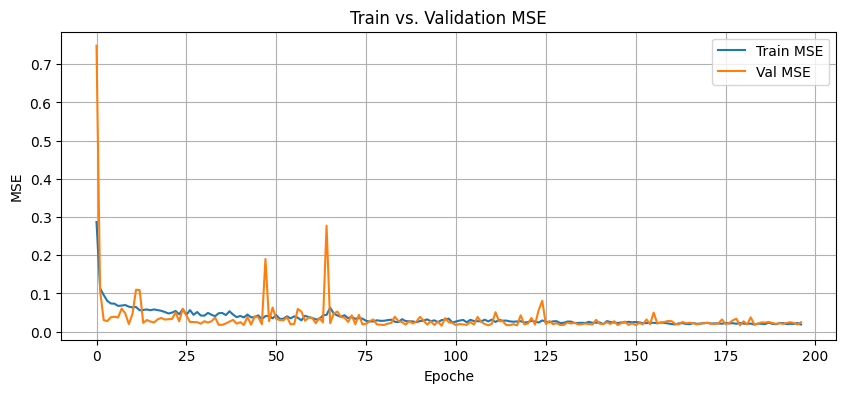

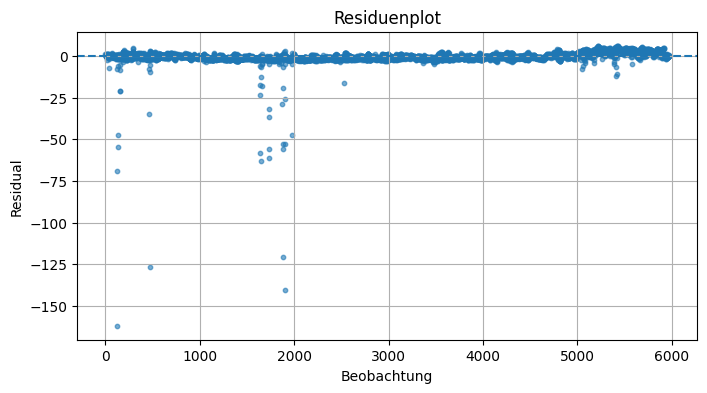

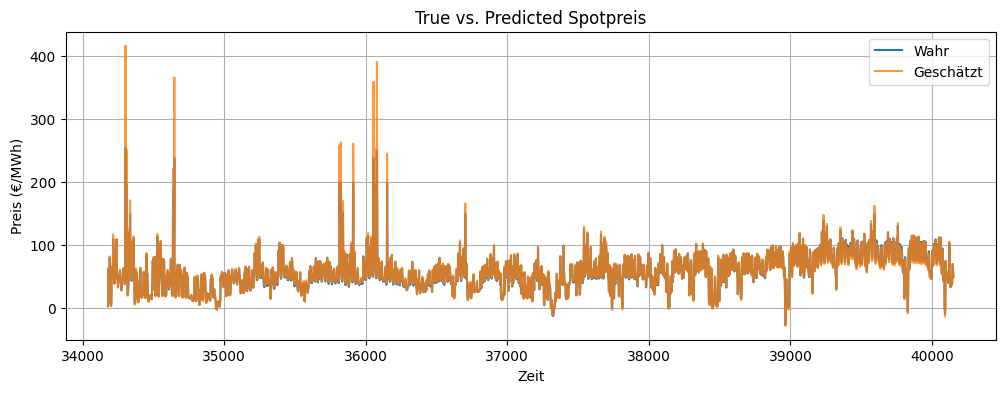

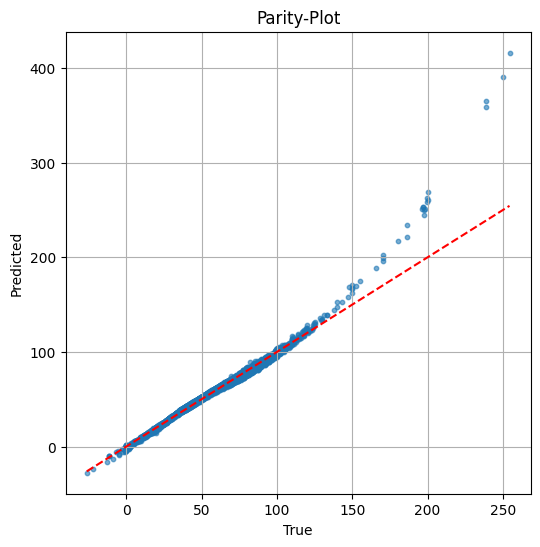

In [9]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    InputLayer, Dense, Dropout, BatchNormalization, LeakyReLU
)
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
)

# ---------------------------------------------------------------------------
# DATENLADEN UND PREPROCESSING
# ---------------------------------------------------------------------------

df = pd.read_csv("Elspotprices.csv", sep=";", decimal=",")
df['HourUTC'] = pd.to_datetime(df['HourUTC'])
df['HourDK']  = pd.to_datetime(df['HourDK'], format="%Y-%m-%d %H:%M") - pd.Timedelta(hours=1)
df = df.set_index('HourUTC').sort_index()

temp_df = pd.read_csv("temperatur_dk_2017_2022.csv", sep=",")
temp_df['time'] = pd.to_datetime(temp_df['time'])
temp_df = temp_df.set_index('time').rename(columns={'temperature_celsius':'temperature_dk'})

df = df.merge(temp_df, left_index=True, right_index=True, how='left')
df['temperature_dk'] = df['temperature_dk'].ffill()
df = df["2017-01-01":"2021-07-31 23:00:00"]

# ---------------------------------------------------------------------------
# FEATURE ENGINEERING
# ---------------------------------------------------------------------------

df = df.reset_index()
df['Stunde']    = df['HourUTC'].dt.hour
df['Wochentag'] = df['HourUTC'].dt.weekday
df['Monat']     = df['HourUTC'].dt.month

for col,freq in [('Stunde',24),('Wochentag',7),('Monat',12)]:
    df[f'{col}_sin'] = np.sin(2*np.pi*df[col]/freq)
    df[f'{col}_cos'] = np.cos(2*np.pi*df[col]/freq)

from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday, EasterMonday, GoodFriday
class DKHolidayCalendar(AbstractHolidayCalendar):
    rules = [
        Holiday("Neujahr",     month=1,  day=1),
        GoodFriday,
        EasterMonday,
        Holiday("Maifeiertag", month=5,  day=1),
        Holiday("Weihnacht1",  month=12, day=25),
        Holiday("Weihnacht2",  month=12, day=26),
    ]
dk_hols = DKHolidayCalendar().holidays(start=df['HourUTC'].min(), end=df['HourUTC'].max())
df['Feiertag'] = df['HourUTC'].dt.normalize().isin(dk_hols).astype(int)

intervals = [("2020-03-01","2021-06-30"), ("2022-02-24","2022-10-19")]
for name,iv in zip(['corona_dummy','russia_ukraine_dummy'], intervals):
    df[name] = ((df['HourUTC']>=iv[0]) & (df['HourUTC']<=iv[1])).astype(int)

lags = [1,24,72,168,336]
for lag in lags:
    df[f'SpotPriceEUR_lag{lag}'] = df['SpotPriceEUR'].shift(lag)

df['SpotPriceEUR_ma24']     = df['SpotPriceEUR'].rolling(24).mean()
df['SpotPriceEUR_ma168']    = df['SpotPriceEUR'].rolling(168).mean()
df['SpotPriceEUR_dev_ma24'] = df['SpotPriceEUR'] - df['SpotPriceEUR_ma24']

df.dropna(inplace=True)
shift = -df['SpotPriceEUR'].min() + 1

# ---------------------------------------------------------------------------
# SPLIT & SCALING
# ---------------------------------------------------------------------------

n = len(df)
i_train, i_val = int(0.7*n), int(0.85*n)
df_train = df.iloc[:i_train].copy()
df_val   = df.iloc[i_train:i_val].copy()
df_test  = df.iloc[i_val:].copy()

for d in (df_train, df_val, df_test):
    d['y_log'] = np.log(d['SpotPriceEUR'] + shift)

feat_cols = ['temperature_dk'] + \
            [f'SpotPriceEUR_lag{lag}' for lag in lags] + \
            ['SpotPriceEUR_ma24','SpotPriceEUR_ma168','SpotPriceEUR_dev_ma24']
scaler_X = MinMaxScaler()
df_train[feat_cols] = scaler_X.fit_transform(df_train[feat_cols])
df_val[feat_cols]   = scaler_X.transform(df_val[feat_cols])
df_test[feat_cols]  = scaler_X.transform(df_test[feat_cols])
joblib.dump(scaler_X, "minmax_scaler_X_ffnn.pkl")

scaler_y = StandardScaler()
df_train['y_scaled'] = scaler_y.fit_transform(df_train[['y_log']])
df_val['y_scaled']   = scaler_y.transform(df_val[['y_log']])
df_test['y_scaled']  = scaler_y.transform(df_test[['y_log']])
joblib.dump(scaler_y, "std_scaler_y_ffnn.pkl")

features = [
    'Stunde_sin','Stunde_cos',
    'Wochentag_sin','Wochentag_cos',
    'Monat_sin','Monat_cos',
    'Feiertag','corona_dummy','russia_ukraine_dummy'
] + feat_cols

X_train = df_train[features].values
y_train = df_train['y_scaled'].values.reshape(-1,1)
X_val   = df_val[features].values
y_val   = df_val['y_scaled'].values.reshape(-1,1)
X_test  = df_test[features].values
y_test  = df_test['y_scaled'].values.reshape(-1,1)

# ---------------------------------------------------------------------------
# MODELLAUFBAU & TRAINING
# ---------------------------------------------------------------------------

n_feat = X_train.shape[1]
model = Sequential([
    InputLayer(input_shape=(n_feat,)),
    Dense(512),            BatchNormalization(), LeakyReLU(), Dropout(0.2),
    Dense(256),            BatchNormalization(), LeakyReLU(), Dropout(0.2),
    Dense(128),            BatchNormalization(), LeakyReLU(),
    Dense(64, activation='elu'), Dropout(0.1),
    Dense(1, activation='linear')
])

optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

es    = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=30, min_lr=1e-6, verbose=1)
chkpt = ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True, verbose=1)
tb    = TensorBoard(log_dir="logs/", histogram_freq=1)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=3000,
    batch_size=64,
    callbacks=[es, rlrop, chkpt, tb],
    verbose=1
)

# ---------------------------------------------------------------------------
# EVALUATION & PLOTS
# ---------------------------------------------------------------------------

# Vorhersage im standardisierten Lograum
y_pred_s = model.predict(X_test)

# Rücktransformation auf EUR/MWh
y_pred_l = scaler_y.inverse_transform(y_pred_s)
y_true_l = scaler_y.inverse_transform(y_test)
y_pred   = np.exp(y_pred_l) - shift
y_true   = np.exp(y_true_l) - shift

# Finale Metriken
mse = np.mean((y_true - y_pred)**2)
mae = np.mean(np.abs(y_true - y_pred))
r2  = 1 - np.sum((y_true - y_pred)**2) / np.sum((y_true - y_true.mean())**2)
print(f"\n--- Finale Metriken (Originalmaßstab) ---")
print(f"MSE: {mse:.2f} | MAE: {mae:.2f} | R²: {r2:.4f}")

# Lernkurven
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='Train MSE')
plt.plot(history.history['val_loss'], label='Val MSE')
plt.xlabel("Epoche"); plt.ylabel("MSE"); plt.title("Train vs. Validation MSE")
plt.legend(); plt.grid(True); plt.show()

# Residuenplot
res = (y_true - y_pred).flatten()
plt.figure(figsize=(8,4))
plt.scatter(np.arange(len(res)), res, s=10, alpha=0.6)
plt.axhline(0, linestyle='--')
plt.xlabel("Beobachtung"); plt.ylabel("Residual"); plt.title("Residuenplot")
plt.grid(True); plt.show()

# Zeitreihenplot True vs. Predicted
plt.figure(figsize=(12,4))
plt.plot(df_test.index, y_true.flatten(), label="Wahr")
plt.plot(df_test.index, y_pred.flatten(), label="Geschätzt", alpha=0.8)
plt.xlabel("Zeit"); plt.ylabel("Preis (€/MWh)")
plt.title("True vs. Predicted Spotpreis")
plt.legend(); plt.grid(True); plt.show()

# Parity-Plot
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, s=10, alpha=0.6)
mn, mx = y_true.min(), y_true.max()
plt.plot([mn,mx], [mn,mx], 'r--')
plt.xlabel("True"); plt.ylabel("Predicted"); plt.title("Parity-Plot")
plt.grid(True); plt.show()


In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input, LSTM, Dense, Dropout, BatchNormalization
)
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
)

# ---------------------------------------------------------------------------
# DATENLADEN UND PREPROCESSING
# ---------------------------------------------------------------------------

df = pd.read_csv("Elspotprices.csv", sep=";", decimal=",")
df['HourUTC'] = pd.to_datetime(df['HourUTC'])
df['HourDK']  = pd.to_datetime(df['HourDK'], format="%Y-%m-%d %H:%M") - pd.Timedelta(hours=1)
df = df.set_index('HourUTC').sort_index()

temp_df = pd.read_csv("temperatur_dk_2017_2022.csv", sep=",")
temp_df['time'] = pd.to_datetime(temp_df['time'])
temp_df = temp_df.set_index('time').rename(columns={'temperature_celsius':'temperature_dk'})

df = df.merge(temp_df, left_index=True, right_index=True, how='left')
df['temperature_dk'] = df['temperature_dk'].ffill()
df = df["2017-01-01":"2021-07-31 23:00:00"]

df = df.reset_index()
df['Stunde']    = df['HourUTC'].dt.hour
df['Wochentag'] = df['HourUTC'].dt.weekday
df['Monat']     = df['HourUTC'].dt.month

for col,freq in [('Stunde',24),('Wochentag',7),('Monat',12)]:
    df[f'{col}_sin'] = np.sin(2*np.pi*df[col]/freq)
    df[f'{col}_cos'] = np.cos(2*np.pi*df[col]/freq)

from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday, EasterMonday, GoodFriday
class DKHolidayCalendar(AbstractHolidayCalendar):
    rules = [
        Holiday("Neujahr",     month=1,  day=1),
        GoodFriday,
        EasterMonday,
        Holiday("Maifeiertag", month=5,  day=1),
        Holiday("Weihnacht1",  month=12, day=25),
        Holiday("Weihnacht2",  month=12, day=26),
    ]
dk_hols = DKHolidayCalendar().holidays(start=df['HourUTC'].min(), end=df['HourUTC'].max())
df['Feiertag'] = df['HourUTC'].dt.normalize().isin(dk_hols).astype(int)

intervals = [("2020-03-01","2021-06-30"), ("2022-02-24","2022-10-19")]
for name,iv in zip(['corona_dummy','russia_ukraine_dummy'], intervals):
    df[name] = ((df['HourUTC']>=iv[0]) & (df['HourUTC']<=iv[1])).astype(int)

lags = [1,24,72,168,336]
for lag in lags:
    df[f'SpotPriceEUR_lag{lag}'] = df['SpotPriceEUR'].shift(lag)

df['SpotPriceEUR_ma24']     = df['SpotPriceEUR'].rolling(24).mean()
df['SpotPriceEUR_ma168']    = df['SpotPriceEUR'].rolling(168).mean()
df['SpotPriceEUR_dev_ma24'] = df['SpotPriceEUR'] - df['SpotPriceEUR_ma24']

df.dropna(inplace=True)
shift = -df['SpotPriceEUR'].min() + 1

# ---------------------------------------------------------------------------
# SPLIT & SCALING
# ---------------------------------------------------------------------------

# Chronologischer Split
n = len(df)
i_train, i_val = int(0.7*n), int(0.85*n)
df_train = df.iloc[:i_train].copy()
df_val   = df.iloc[i_train:i_val].copy()
df_test  = df.iloc[i_val:].copy()

# Zielvariable log-transform und standardisieren
scaler_y = StandardScaler()
for d in (df_train, df_val, df_test):
    d['y_log'] = np.log(d['SpotPriceEUR'] + shift)
df_train['y_scaled'] = scaler_y.fit_transform(df_train[['y_log']])
df_val['y_scaled']   = scaler_y.transform(df_val[['y_log']])
df_test['y_scaled']  = scaler_y.transform(df_test[['y_log']])
joblib.dump(scaler_y, "std_scaler_y_lstm.pkl")

# Features skalieren (MinMax)
feat_cols = ['temperature_dk'] + \
            [f'SpotPriceEUR_lag{lag}' for lag in lags] + \
            ['SpotPriceEUR_ma24','SpotPriceEUR_ma168','SpotPriceEUR_dev_ma24'] + \
            ['Stunde_sin','Stunde_cos','Wochentag_sin','Wochentag_cos',
             'Monat_sin','Monat_cos','Feiertag','corona_dummy','russia_ukraine_dummy']

scaler_X = MinMaxScaler()
df_train[feat_cols] = scaler_X.fit_transform(df_train[feat_cols])
df_val[feat_cols]   = scaler_X.transform(df_val[feat_cols])
df_test[feat_cols]  = scaler_X.transform(df_test[feat_cols])
joblib.dump(scaler_X, "minmax_scaler_X_lstm.pkl")

# ---------------------------------------------------------------------------
# SEQUENCES FÜR LSTM ERZEUGEN
# ---------------------------------------------------------------------------

def make_sequences(df, feat_cols, target_col, seq_len=24):
    X, y = [], []
    data = df[feat_cols + [target_col]].values
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i, :-1])
        y.append(data[i, -1])
    return np.array(X), np.array(y)

SEQ_LEN = 24
X_train, y_train = make_sequences(df_train, feat_cols, 'y_scaled', SEQ_LEN)
X_val,   y_val   = make_sequences(df_val,   feat_cols, 'y_scaled', SEQ_LEN)
X_test,  y_test  = make_sequences(df_test,  feat_cols, 'y_scaled', SEQ_LEN)

# ---------------------------------------------------------------------------
# LSTM-MODELL
# ---------------------------------------------------------------------------

n_feats = X_train.shape[2]
model = Sequential([
    Input(shape=(SEQ_LEN, n_feats)),
    LSTM(128, return_sequences=True),
    BatchNormalization(),
    Dropout(0.2),

    LSTM(64),
    BatchNormalization(),
    Dropout(0.2),

    Dense(32, activation='relu'),
    Dense(1, activation='linear'),
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mse',
    metrics=['mae']
)

# ---------------------------------------------------------------------------
# CALLBACKS & TRAINING
# ---------------------------------------------------------------------------

es    = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, min_lr=1e-6, verbose=1)
chkpt = ModelCheckpoint("best_lstm.h5", monitor='val_loss', save_best_only=True, verbose=1)
tb    = TensorBoard(log_dir="logs/lstm", histogram_freq=1)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=300,
    batch_size=64,
    callbacks=[es, rlrop, chkpt, tb],
    verbose=1
)

# ---------------------------------------------------------------------------
# EVALUATION & PLOTS
# ---------------------------------------------------------------------------

# Vorhersage
y_pred_s = model.predict(X_test)

# Rücktransformation in Originalmaßstab
y_pred_l = scaler_y.inverse_transform(y_pred_s.reshape(-1,1))
y_true_l = scaler_y.inverse_transform(y_test.reshape(-1,1))
y_pred   = np.exp(y_pred_l) - shift
y_true   = np.exp(y_true_l) - shift

# Metriken
mse = np.mean((y_true - y_pred)**2)
mae = np.mean(np.abs(y_true - y_pred))
r2  = 1 - np.sum((y_true - y_pred)**2) / np.sum((y_true - y_true.mean())**2)
print(f"\n--- Finale Metriken (Originalmaßstab) ---")
print(f"MSE: {mse:.2f} | MAE: {mae:.2f} | R²: {r2:.4f}")

# Lernkurven
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='Train MSE')
plt.plot(history.history['val_loss'], label='Val MSE')
plt.xlabel("Epoche"); plt.ylabel("MSE"); plt.title("Train vs. Validation MSE")
plt.legend(); plt.grid(True); plt.show()

# Residuenplot
res = (y_true - y_pred).flatten()
plt.figure(figsize=(8,4))
plt.scatter(np.arange(len(res)), res, s=10, alpha=0.6)
plt.axhline(0, linestyle='--')
plt.xlabel("Beobachtung"); plt.ylabel("Residual"); plt.title("Residuenplot")
plt.grid(True); plt.show()

# Zeitreihe True vs. Predicted
plt.figure(figsize=(12,4))
plt.plot(df_test.index[SEQ_LEN:], y_true.flatten(), label="Wahr")
plt.plot(df_test.index[SEQ_LEN:], y_pred.flatten(), label="Geschätzt", alpha=0.8)
plt.xlabel("Zeit"); plt.ylabel("Preis (€/MWh)")
plt.title("True vs. Predicted Spotpreis")
plt.legend(); plt.grid(True); plt.show()

# Parity-Plot
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, s=10, alpha=0.6)
mn, mx = y_true.min(), y_true.max()
plt.plot([mn,mx],[mn,mx],'r--')
plt.xlabel("True"); plt.ylabel("Predicted"); plt.title("Parity-Plot")
plt.grid(True); plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'Elspotprices.csv'

In [ ]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    InputLayer, Dense, Dropout, LeakyReLU
)
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
)

# ---------------------------------------------------------------------------
# DATENLADEN UND PREPROCESSING
# ---------------------------------------------------------------------------

df = pd.read_csv("Elspotprices.csv", sep=";", decimal=",")
df['HourUTC'] = pd.to_datetime(df['HourUTC'])
df['HourDK']  = pd.to_datetime(df['HourDK'], format="%Y-%m-%d %H:%M") - pd.Timedelta(hours=1)
df = df.set_index('HourUTC').sort_index()

temp_df = pd.read_csv("temperatur_dk_2017_2022.csv", sep=",")
temp_df['time'] = pd.to_datetime(temp_df['time'])
temp_df = temp_df.set_index('time').rename(columns={'temperature_celsius':'temperature_dk'})

df = df.merge(temp_df, left_index=True, right_index=True, how='left')
df['temperature_dk'] = df['temperature_dk'].ffill()
df = df["2017-01-01":"2021-07-31 23:00:00"]

# ---------------------------------------------------------------------------
# FEATURE ENGINEERING
# ---------------------------------------------------------------------------

df = df.reset_index()
df['Stunde']    = df['HourUTC'].dt.hour
df['Wochentag'] = df['HourUTC'].dt.weekday
df['Monat']     = df['HourUTC'].dt.month

for col,freq in [('Stunde',24),('Wochentag',7),('Monat',12)]:
    df[f'{col}_sin'] = np.sin(2*np.pi*df[col]/freq)
    df[f'{col}_cos'] = np.cos(2*np.pi*df[col]/freq)

from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday, EasterMonday, GoodFriday
class DKHolidayCalendar(AbstractHolidayCalendar):
    rules = [
        Holiday("Neujahr",     month=1,  day=1),
        GoodFriday,
        EasterMonday,
        Holiday("Maifeiertag", month=5,  day=1),
        Holiday("Weihnacht1",  month=12, day=25),
        Holiday("Weihnacht2",  month=12, day=26),
    ]
dk_hols = DKHolidayCalendar().holidays(start=df['HourUTC'].min(), end=df['HourUTC'].max())
df['Feiertag'] = df['HourUTC'].dt.normalize().isin(dk_hols).astype(int)

intervals = [("2020-03-01","2021-06-30"), ("2022-02-24","2022-10-19")]
for name,iv in zip(['corona_dummy','russia_ukraine_dummy'], intervals):
    df[name] = ((df['HourUTC']>=iv[0]) & (df['HourUTC']<=iv[1])).astype(int)

lags = [1,24,72,168,336]
for lag in lags:
    df[f'SpotPriceEUR_lag{lag}'] = df['SpotPriceEUR'].shift(lag)

df['SpotPriceEUR_ma24']     = df['SpotPriceEUR'].rolling(24).mean()
df['SpotPriceEUR_ma168']    = df['SpotPriceEUR'].rolling(168).mean()
df['SpotPriceEUR_dev_ma24'] = df['SpotPriceEUR'] - df['SpotPriceEUR_ma24']

df.dropna(inplace=True)
shift = -df['SpotPriceEUR'].min() + 1

# ---------------------------------------------------------------------------
# SPLIT & SCALING
# ---------------------------------------------------------------------------

n = len(df)
i_train, i_val = int(0.7*n), int(0.85*n)
df_train = df.iloc[:i_train].copy()
df_val   = df.iloc[i_train:i_val].copy()
df_test  = df.iloc[i_val:].copy()

for d in (df_train, df_val, df_test):
    d['y_log'] = np.log(d['SpotPriceEUR'] + shift)

feat_cols = ['temperature_dk'] + \
            [f'SpotPriceEUR_lag{lag}' for lag in lags] + \
            ['SpotPriceEUR_ma24','SpotPriceEUR_ma168','SpotPriceEUR_dev_ma24']
scaler_X = MinMaxScaler()
df_train[feat_cols] = scaler_X.fit_transform(df_train[feat_cols])
df_val[feat_cols]   = scaler_X.transform(df_val[feat_cols])
df_test[feat_cols]  = scaler_X.transform(df_test[feat_cols])
joblib.dump(scaler_X, "minmax_scaler_X_ffnn_no_bn.pkl")

scaler_y = StandardScaler()
df_train['y_scaled'] = scaler_y.fit_transform(df_train[['y_log']])
df_val['y_scaled']   = scaler_y.transform(df_val[['y_log']])
df_test['y_scaled']  = scaler_y.transform(df_test[['y_log']])
joblib.dump(scaler_y, "std_scaler_y_ffnn_no_bn.pkl")

features = [
    'Stunde_sin','Stunde_cos',
    'Wochentag_sin','Wochentag_cos',
    'Monat_sin','Monat_cos',
    'Feiertag','corona_dummy','russia_ukraine_dummy'
] + feat_cols

X_train = df_train[features].values
y_train = df_train['y_scaled'].values.reshape(-1,1)
X_val   = df_val[features].values
y_val   = df_val['y_scaled'].values.reshape(-1,1)
X_test  = df_test[features].values
y_test  = df_test['y_scaled'].values.reshape(-1,1)

# ---------------------------------------------------------------------------
# MODELLAUFBAU & TRAINING OHNE BATCHNORM
# ---------------------------------------------------------------------------

n_feat = X_train.shape[1]
model = Sequential([
    InputLayer(input_shape=(n_feat,)),
    Dense(512), LeakyReLU(), Dropout(0.2),
    Dense(256), LeakyReLU(), Dropout(0.2),
    Dense(128), LeakyReLU(),
    Dense(64, activation='elu'), Dropout(0.1),
    Dense(1, activation='linear')
])

optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

es    = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=30, min_lr=1e-6, verbose=1)
chkpt = ModelCheckpoint("best_model_no_bn.h5", monitor='val_loss', save_best_only=True, verbose=1)
tb    = TensorBoard(log_dir="logs_no_bn/", histogram_freq=1)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=3000,
    batch_size=64,
    callbacks=[es, rlrop, chkpt, tb],
    verbose=1
)

# ---------------------------------------------------------------------------
# EVALUATION & PLOTS (unverändert)
# ---------------------------------------------------------------------------

y_pred_s = model.predict(X_test)
y_pred_l = scaler_y.inverse_transform(y_pred_s)
y_true_l = scaler_y.inverse_transform(y_test)
y_pred   = np.exp(y_pred_l) - shift
y_true   = np.exp(y_true_l) - shift

mse = np.mean((y_true - y_pred)**2)
mae = np.mean(np.abs(y_true - y_pred))
r2  = 1 - np.sum((y_true - y_pred)**2) / np.sum((y_true - y_true.mean())**2)
print(f"\n--- Finale Metriken (Originalmaßstab, no BN) ---")
print(f"MSE: {mse:.2f} | MAE: {mae:.2f} | R²: {r2:.4f}")

# ... restliche Plots wie gehabt ...
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='Train MSE')
plt.plot(history.history['val_loss'], label='Val MSE')
plt.xlabel("Epoche"); plt.ylabel("MSE"); plt.title("Train vs. Validation MSE")
plt.legend(); plt.grid(True); plt.show()

# Residuenplot
res = (y_true - y_pred).flatten()
plt.figure(figsize=(8,4))
plt.scatter(np.arange(len(res)), res, s=10, alpha=0.6)
plt.axhline(0, linestyle='--')
plt.xlabel("Beobachtung"); plt.ylabel("Residual"); plt.title("Residuenplot")
plt.grid(True); plt.show()

# Zeitreihenplot True vs. Predicted
plt.figure(figsize=(12,4))
plt.plot(df_test.index, y_true.flatten(), label="Wahr")
plt.plot(df_test.index, y_pred.flatten(), label="Geschätzt", alpha=0.8)
plt.xlabel("Zeit"); plt.ylabel("Preis (€/MWh)")
plt.title("True vs. Predicted Spotpreis")
plt.legend(); plt.grid(True); plt.show()

# Parity-Plot
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, s=10, alpha=0.6)
mn, mx = y_true.min(), y_true.max()
plt.plot([mn,mx], [mn,mx], 'r--')
plt.xlabel("True"); plt.ylabel("Predicted"); plt.title("Parity-Plot")
plt.grid(True); plt.show()